This notebook tries to implement the following:


- w-lookahead policy: we implementing future info for testing different policies (heuristic: upon beginning of service, look w-ahead. if the # departures in that time < # arrivals at the slow service rate, use the fast service rate. otherwise, use the slow service rate). 



In [1]:
%matplotlib inline
from pylab import *
import sys
from collections import namedtuple
import random
import time
import numpy as np

In [2]:
def log_normal(mu=0, sigma=1):
    return e**(mu+sigma*np.random.normal())

def exp_samples(lambd=1,n=1):
    """
    generates a numpy array of n samples distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand(n))

def exp(lambd=1):
    """
    generates a sample distributed according to
    an exponential distribution with parameter λ
    """
    if lambd < 0:
        return inf()
    random.seed(time.time())
    return (-1/lambd)*log(rand())

def inf():
    return 9999


def printarray(a): 
    print(np.around(a, 3))
    

# Define customer for the threshold policy
Customer = namedtuple("Customer", "arrival_time")
def customer(arrival_time=-1):
    return Customer(arrival_time=arrival_time)

# Define customer for the w-lookahead policy
# mu1 is the slow service rate and mu2 is the fast service rate
WCustomer = namedtuple("WCustomer", "arrival_time slow_service_time fast_service_time service_time arrival_index")
def wcustomer(arrival_time=-1, mu1=-1, mu2=-1, arrival_index=0):
    #slow = exp(mu1)
    #fast = slow * mu1/mu2
    slow = 2
    fast = 1
    return WCustomer(arrival_time=arrival_time, slow_service_time=slow,
                        fast_service_time=fast, service_time=-1, arrival_index=arrival_index)

def wcustomer_with_parameters(w, current_time, fast):
    if fast:
        return WCustomer(arrival_time=w.arrival_time, slow_service_time=w.slow_service_time,
                         fast_service_time=w.fast_service_time, service_time=current_time+w.fast_service_time,
                         arrival_index=w.arrival_index)
    return WCustomer(arrival_time=w.arrival_time, slow_service_time=w.slow_service_time,
                     fast_service_time=w.fast_service_time, service_time=current_time+w.slow_service_time,
                     arrival_index=w.arrival_index)

In [3]:
# Example 2: M/M/1 queue starting as empty
# lambd = arrival rate
# mu1 = pre-surge service rate
# mu2 = post-surge service rate
# c = number of servers (1)
# w = the amount of time to look ahead
# Tmax = time horizon

# Heuristic:  upon beginning of service, look w-ahead. if the # departures in
# that time < # arrivals at the slow service rate, use the fast service rate.
# otherwise, use the slow service rate

# Constant arrival and departure rates for testing whether this works

def MM1WithWLookaheadConstant(lambd, mu1, mu2, c, w, Tmax):
    T             = [0]  # list of times that events occur in real time
    T_advance     = [0]  # list of events that get generated in advance
    t_temp        = 0    # temporary time to calculate delta
    N             = [0] # initial state of the system
    S             = 0    # area under curve starting with T=1000
    in_surge      = 0    # time spent in surge
    start_measuring_surge = 0
    p_wait_num = 0
    p_wait_denom = 0
    
    # customers currently being served by a server
    servers = []
    
    # customers that are waiting to be served by a server
    queue = []
    
    # times spent by users inside the system
    waiting_times = []
    
    # generate arrivals independent of whether or not we speed up the customers
    arrivals = []
    while T_advance[-1] < Tmax:
        t_temp = T_advance[-1]
        next_arrival = t_temp + 1
        T_advance.append(next_arrival)
        arrivals.append(wcustomer(next_arrival, mu1, mu2, len(T_advance) - 2))
    
    # arrival index represents when we either add to queue or to server if it's free
    arrival_index = 0
    
    # first event must be an arrival
    next_arrival = arrivals[arrival_index].arrival_time
    next_departure = inf()
    
    while T[-1] < Tmax:
        t_temp = T[-1]
        
        T.append(min(next_arrival, next_departure))
        
        ##### ARRIVAL ##### 
        if T[-1] == next_arrival:
            N.append(N[-1]+1) 
            arrival = arrivals[arrival_index]
            arrival_index += 1
            if len(servers) < c:
                # w-lookahead: decide whether to use fast or slow service rate
                cumulative_service_time = T[-1]
                w_lookahead = T[-1] + w
                num_arrivals = 0
                num_departures = 0
                for i in range(arrival_index, len(arrivals) - 1):
                    if arrivals[i].arrival_time > w_lookahead:
                        break
                    else:
                        num_arrivals += 1
                for i in range(arrival.arrival_index - 1, len(arrivals) - 1):
                    cumulative_service_time += arrivals[i].slow_service_time
                    if cumulative_service_time > w_lookahead:
                        break
                    else:
                        num_departures += 1
                if num_departures >= num_arrivals: # use the slow service rate   
                    servers.append(wcustomer_with_parameters(arrival, T[-1], False))
                    print("Look ahead at time %.3f has Departures %d Arrivals %d -> use SLOW" % (T[-1], num_departures, num_arrivals))
                else: # use the fast service rate
                    servers.append(wcustomer_with_parameters(arrival, T[-1], True))
                    print("Look ahead at time %.3f has Departures %d Arrivals %d -> use FAST" % (T[-1], num_departures, num_arrivals))
        
            else:
                queue.append(arrival)
                p_wait_num += 1
            p_wait_denom+=1
            if arrival_index < len(arrivals):
                next_arrival = arrivals[arrival_index].arrival_time
            else:
                next_arrival = inf()
            #print("ARRIVAL %.3f departure %.3f abandonment %.3f" % (next_arrival, next_departure, next_abandonment))
        ##### DEPARTURE #####     
        elif T[-1] == next_departure:
            N.append(N[-1]-1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)            
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                # w-lookahead: decide whether to use fast or slow service rate
                cumulative_service_time = T[-1]
                w_lookahead = T[-1] + w
                num_arrivals = 0
                num_departures = 0
                for i in range(arrival_index, len(arrivals) - 1):
                    if arrivals[i].arrival_time > w_lookahead:
                        break
                    else:
                        num_arrivals += 1
                for i in range(arrival.arrival_index - 1, len(arrivals) - 1):
                    cumulative_service_time += arrivals[i].slow_service_time
                    if cumulative_service_time > w_lookahead:
                        break
                    else:
                        num_departures += 1
                if num_departures >= num_arrivals: # use the slow service rate   
                    servers.append(wcustomer_with_parameters(arrival, T[-1], False))
                    print("Look ahead at time %.3f has Departures %d Arrivals %d -> use SLOW" % (T[-1], num_departures, num_arrivals))
                else: # use the fast service rate
                    servers.append(wcustomer_with_parameters(arrival, T[-1], True))
                    print("Look ahead at time %.3f has Departures %d Arrivals %d -> use FAST" % (T[-1], num_departures, num_arrivals))
        
        
        
        if len(servers) > 0:
            next_departure = servers[0].service_time
        else:
            next_departure = inf()
        
        ##### SURGE count and proportion #####
        if T[-1] > 1000:
            if in_surge == 0 and S == 0: # first time, mark t_temp
                start_measuring_surge = T[-2]
            t_delta = T[-1] - T[-2]
            S = S + (t_delta * N[-2])
            if N[-2] >= surge_threshold:
                in_surge = in_surge + t_delta

    S = S / (T[-1] - start_measuring_surge)
    in_surge = in_surge / (T[-1] - start_measuring_surge)
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times, S, in_surge

 Here we have a 2.5 time lookahead. At each process' arrival, the lookahead sees the departure
        of that arrival, but the arrival of two other processes. Thus, all processes are processed at
        the faster rate.
Look ahead at time 1.000 has Departures 1 Arrivals 2 -> use FAST
Look ahead at time 2.000 has Departures 1 Arrivals 2 -> use FAST
Look ahead at time 3.000 has Departures 1 Arrivals 2 -> use FAST
Look ahead at time 4.000 has Departures 1 Arrivals 1 -> use SLOW


Text(0.5,1,'Number of clients in the M/[slow M+fast M]/C queue 0.00/0.00+0.00/1, with 2.50-time lookahead')

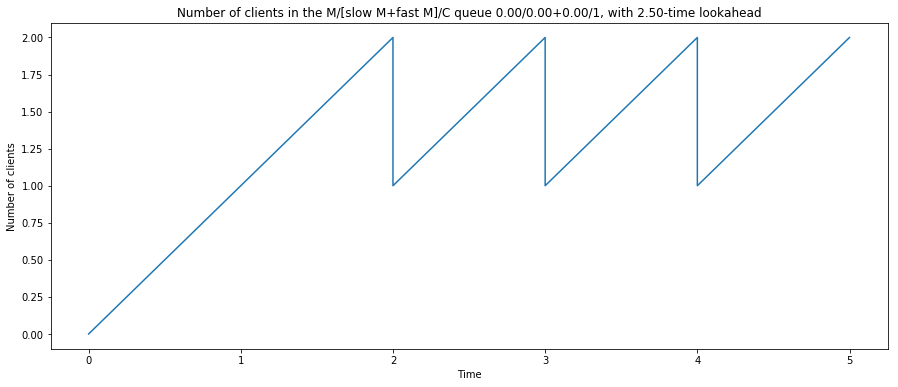

In [4]:
lambd = 0
mu1 = 0
mu2 = 0
c = 1
w = 2.5
Tmax = 6

s = """ Here we have a 2.5 time lookahead. At each process' arrival, the lookahead sees the departure
        of that arrival, but the arrival of two other processes. Thus, all processes are processed at
        the faster rate."""

print(s)

T, N, W, S, in_surge = MM1WithWLookaheadConstant(lambd, mu1, mu2, c, w, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/[slow M+fast M]/C queue %.2f/%.2f+%.2f/%d, with %.2f-time lookahead'
      % (lambd, mu1, mu2, c, w))


 Here we have a 0 time lookahead (online policy). No processes are processed at
        the faster rate.
Look ahead at time 1.000 has Departures 0 Arrivals 0 -> use SLOW
Look ahead at time 3.000 has Departures 0 Arrivals 0 -> use SLOW
Look ahead at time 5.000 has Departures 0 Arrivals 0 -> use SLOW


Text(0.5,1,'Number of clients in the M/[slow M+fast M]/C queue 0.00/0.00+0.00/1, with 0.00-time lookahead')

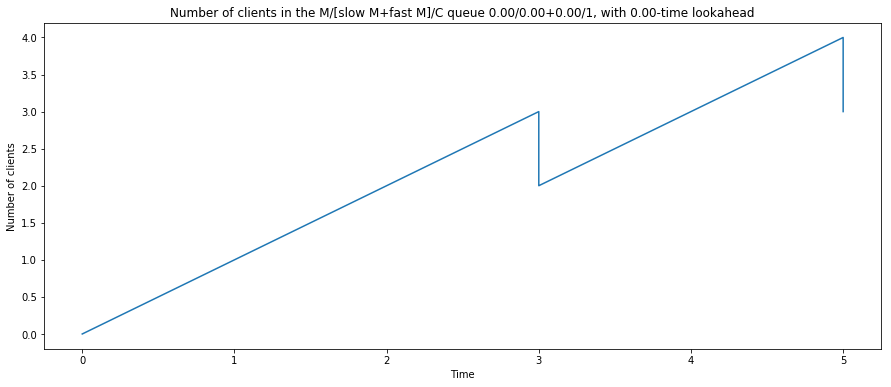

In [5]:
lambd = 0
mu1 = 0
mu2 = 0
c = 1
w = 0
Tmax = 6

s = """ Here we have a 0 time lookahead (online policy). No processes are processed at
        the faster rate."""

print(s)

T, N, W, S, in_surge = MM1WithWLookaheadConstant(lambd, mu1, mu2, c, w, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/[slow M+fast M]/C queue %.2f/%.2f+%.2f/%d, with %.2f-time lookahead'
      % (lambd, mu1, mu2, c, w))


 Here we have a 0.5 time lookahead. Similar to the 0, no processes are processed at the
faster rate, since the lookahead cannot see the next arrival.
Look ahead at time 1.000 has Departures 0 Arrivals 0 -> use SLOW
Look ahead at time 3.000 has Departures 0 Arrivals 0 -> use SLOW
Look ahead at time 5.000 has Departures 0 Arrivals 0 -> use SLOW


Text(0.5,1,'Number of clients in the M/[slow M+fast M]/C queue 0.00/0.00+0.00/1, with 0.50-time lookahead')

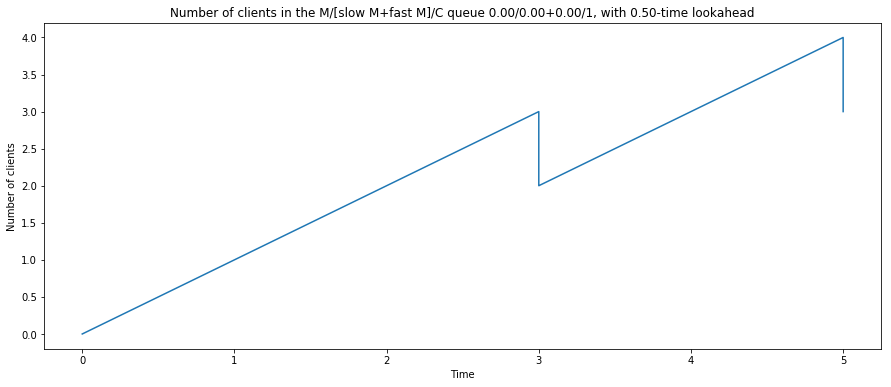

In [6]:
lambd = 0
mu1 = 0
mu2 = 0
c = 1
w = 0.5
Tmax = 6

s = """ Here we have a 0.5 time lookahead. Similar to the 0, no processes are processed at the
faster rate, since the lookahead cannot see the next arrival."""

print(s)

T, N, W, S, in_surge = MM1WithWLookaheadConstant(lambd, mu1, mu2, c, w, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/[slow M+fast M]/C queue %.2f/%.2f+%.2f/%d, with %.2f-time lookahead'
      % (lambd, mu1, mu2, c, w))


 Here we have a 1 time lookahead. Similar to the 2.5, the lookahead can
see the next arrival and surges.
Look ahead at time 1.000 has Departures 0 Arrivals 1 -> use FAST
Look ahead at time 2.000 has Departures 0 Arrivals 1 -> use FAST
Look ahead at time 3.000 has Departures 0 Arrivals 1 -> use FAST
Look ahead at time 4.000 has Departures 0 Arrivals 1 -> use FAST
Look ahead at time 5.000 has Departures 0 Arrivals 0 -> use SLOW


Text(0.5,1,'Number of clients in the M/[slow M+fast M]/C queue 0.00/0.00+0.00/1, with 1.00-time lookahead')

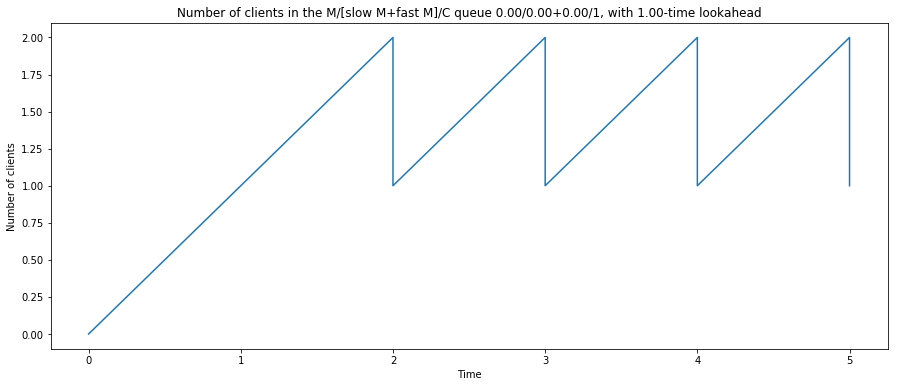

In [7]:
lambd = 0
mu1 = 0
mu2 = 0
c = 1
w = 1
Tmax = 6

s = """ Here we have a 1 time lookahead. Similar to the 2.5, the lookahead can
see the next arrival and surges."""

print(s)

T, N, W, S, in_surge = MM1WithWLookaheadConstant(lambd, mu1, mu2, c, w, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/[slow M+fast M]/C queue %.2f/%.2f+%.2f/%d, with %.2f-time lookahead'
      % (lambd, mu1, mu2, c, w))


 Here we have a 5 time lookahead. Similar to the 2.5, the lookahead can
see the next arrival and surges.
Look ahead at time 1.000 has Departures 2 Arrivals 4 -> use FAST
Look ahead at time 2.000 has Departures 2 Arrivals 3 -> use FAST
Look ahead at time 3.000 has Departures 2 Arrivals 2 -> use SLOW
Look ahead at time 5.000 has Departures 2 Arrivals 0 -> use SLOW


Text(0.5,1,'Number of clients in the M/[slow M+fast M]/C queue 0.00/0.00+0.00/1, with 4.00-time lookahead')

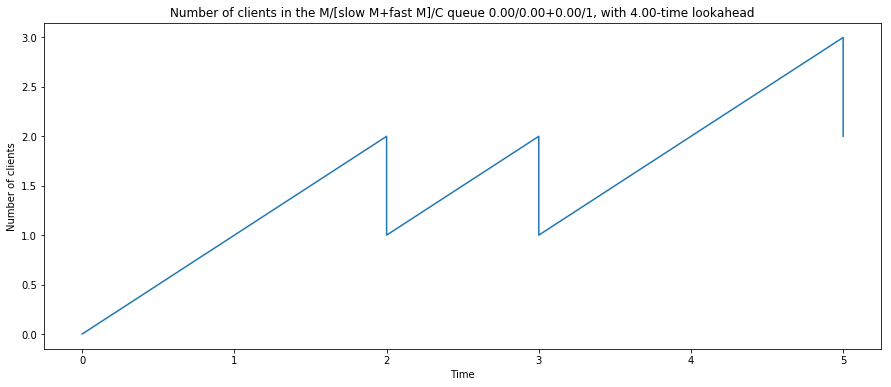

In [8]:
lambd = 0
mu1 = 0
mu2 = 0
c = 1
w = 4
Tmax = 6

s = """ Here we have a 5 time lookahead. Similar to the 2.5, the lookahead can
see the next arrival and surges."""

print(s)

T, N, W, S, in_surge = MM1WithWLookaheadConstant(lambd, mu1, mu2, c, w, Tmax)
figure(figsize=(15,6))
plot(T, N)
xlabel('Time')
ylabel('Number of clients')
title('Number of clients in the M/[slow M+fast M]/C queue %.2f/%.2f+%.2f/%d, with %.2f-time lookahead'
      % (lambd, mu1, mu2, c, w))
